In [341]:
import numpy as np
import pandas as pd
import ipaddress
from urllib.parse import urlparse
from ipaddress import *
import seaborn as sns
import matplotlib.pyplot as plt
import re
sns.set_style(style='white') 
data=pd.read_csv('data_urls.csv')

In [342]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822010 entries, 0 to 822009
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     822010 non-null  object
 1   status  822010 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 12.5+ MB


In [343]:
data.dropna()
data.drop_duplicates()

,url,status
0,0000111servicehelpdesk.godaddysites.com,0
1,000011accesswebform.godaddysites.com,0
2,00003.online,0
3,0009servicedeskowa.godaddysites.com,0
4,000n38p.wcomhost.com,0
...,...,...
822005,zzufg.com,0
822006,zzu.li,0
822007,zzz.co.uk,0
822008,zzzoolight.co.za,0


In [428]:
def top_domain(url): 
    try: 
        dom = urlparse(url).netloc
        if dom:
            dom=dom.split('.')[-1]
            return dom
                
        else:
            ind=url.index('/')
            url=url[:ind]
    except:
        pass
    dom=url.split('.')[-1]
    if dom.isdigit():
        dom=0
    return dom

def domain(url):
    try:
        dom = urlparse(url).netloc
        if dom:
            if re.match(r"^www.",domain):
                dom = dom.replace("www.","")
                dom=dom.split('.')[0]
        else:
            ind=url.index('/')
            url=url[:ind]
            url=url.split('.')
            url=url[:-1]
            dom=".".join(url)
    except:
        url=url.split('.')
        url=url[:-1]
        dom=".".join(url)
    
    return dom



def is_ipAddress(url):
    try:
        ipaddress.ip_address(url)
        ip = 1 #yes
    except:
        ip = 0 #no
    return ip

def is_https(url):
    scheme = urlparse(url).scheme
    if scheme =='https':
         return 1 #yes
    else:
        return 0 #no
    
def get_depth(url):
    s = urlparse(url).path.split('/')
    depth = 0
    for j in range(len(s)):
        if len(s[j]) != 0:
            depth = depth+1
    return depth


In [429]:
# data.loc[data['top_domain']=='com/']

In [430]:
print(urlparse(data['url'].iloc[28684]))

ParseResult(scheme='https', netloc='client-espace-service-ml.000webhostapp.com', path='/', params='', query='', fragment='')


In [431]:
data['url_length'] = data['url'].apply(len)
data['class']=data['status'].apply(lambda x:  'phishing'if x==0 else 'legitimate')
data['num_special_chars'] = data['url'].apply(lambda x: sum([1 for char in x if char in ['@', '-', '?', '=']]))
data['num_subdomains'] = data['url'].apply(lambda x: len(x.split('.')) - 2)
data['num_digits']=data['url'].apply(lambda x: sum([1 for char in x if str(char).isdigit()]))
data['num_dots']= data['url'].apply(lambda x: sum([1 for char in x if char=='.']))
data['num_slash']= data['url'].apply(lambda x: sum([1 for char in x if char=='/']))
data['num_and']= data['url'].apply(lambda x: sum([1 for char in x if char=='&']))
data['num_percent']= data['url'].apply(lambda x: sum([1 for char in x if char=='%']))
data['domain']=data['url'].apply(domain)
data['is_IP']=data['url'].apply(is_ipAddress)
data['is_HTTPS']=data['url'].apply(is_https)
data['depth']=data['url'].apply(get_depth)

In [432]:
data.head()

,url,status,url_length,class,num_special_chars,num_subdomains,num_digits,num_dots,top_domain,domain,is_IP,is_HTTPS,depth,num_slash,num_and,num_percent
0,0000111servicehelpdesk.godaddysites.com,0,39,phishing,0,1,7,2,com,0000111servicehelpdesk.godaddysites,0,0,1,0,0,0
1,000011accesswebform.godaddysites.com,0,36,phishing,0,1,6,2,com,000011accesswebform.godaddysites,0,0,1,0,0,0
2,00003.online,0,12,phishing,0,0,5,1,online,00003,0,0,1,0,0,0
3,0009servicedeskowa.godaddysites.com,0,35,phishing,0,1,4,2,com,0009servicedeskowa.godaddysites,0,0,1,0,0,0
4,000n38p.wcomhost.com,0,20,phishing,0,1,5,2,com,000n38p.wcomhost,0,0,1,0,0,0


/home/lab_services_student/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='class', ylabel='count'>

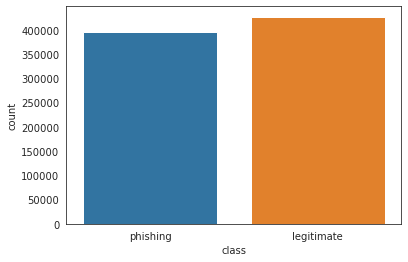

In [433]:
sns.countplot(data['class'])

In [434]:
data.loc[data['is_IP']==1]

,url,status,url_length,class,num_special_chars,num_subdomains,num_digits,num_dots,top_domain,domain,is_IP,is_HTTPS,depth,num_slash,num_and,num_percent
92,103.114.104.87,0,14,phishing,0,2,11,3,87,103.114.104,1,0,1,0,0,0
93,103.119.0.224,0,13,phishing,0,2,10,3,224,103.119.0,1,0,1,0,0,0
94,103.119.30.176,0,14,phishing,0,2,11,3,176,103.119.30,1,0,1,0,0,0
95,103.195.100.74,0,14,phishing,0,2,11,3,74,103.195.100,1,0,1,0,0,0
96,103.195.7.246,0,13,phishing,0,2,10,3,246,103.195.7,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751914,94.177.203.169,0,14,phishing,0,2,11,3,169,94.177.203,1,0,1,0,0,0
751915,94.177.242.164,0,14,phishing,0,2,11,3,164,94.177.242,1,0,1,0,0,0
751916,94.177.250.193,0,14,phishing,0,2,11,3,193,94.177.250,1,0,1,0,0,0
751917,94.177.254.180,0,14,phishing,0,2,11,3,180,94.177.254,1,0,1,0,0,0


In [435]:
data.describe()

,status,url_length,num_special_chars,num_subdomains,num_digits,num_dots,is_IP,is_HTTPS,depth,num_slash,num_and,num_percent
count,822010.000000,822010.000000,822010.000000,822010.000000,822010.000000,822010.000000,822010.000000,822010.000000,822010.000000,822010.000000,822010.000000,822010.000000
mean,0.519492,47.089802,1.341099,1.132614,3.985646,2.132614,0.002029,0.161550,2.362104,2.501928,0.105501,0.075775
std,0.499620,42.556054,2.505930,1.505595,10.932098,1.505595,0.045001,0.368038,1.783666,1.852917,0.733197,1.167017
min,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,26.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,1.000000,37.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
75%,1.000000,55.000000,2.000000,1.000000,4.000000,2.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000
max,1.000000,3992.000000,197.000000,36.000000,1575.000000,37.000000,1.000000,1.000000,35.000000,51.000000,37.000000,253.000000


In [436]:
data.top_domain.describe()

count     822010
unique      1878
top          com
freq      473795
Name: top_domain, dtype: object

In [437]:
data.top_domain.value_counts()[:10]

com    473795
org     68260
cn      38091
net     31287
top     12645
ca      11476
edu     10854
uk      10573
ru       8358
br       7091
Name: top_domain, dtype: int64

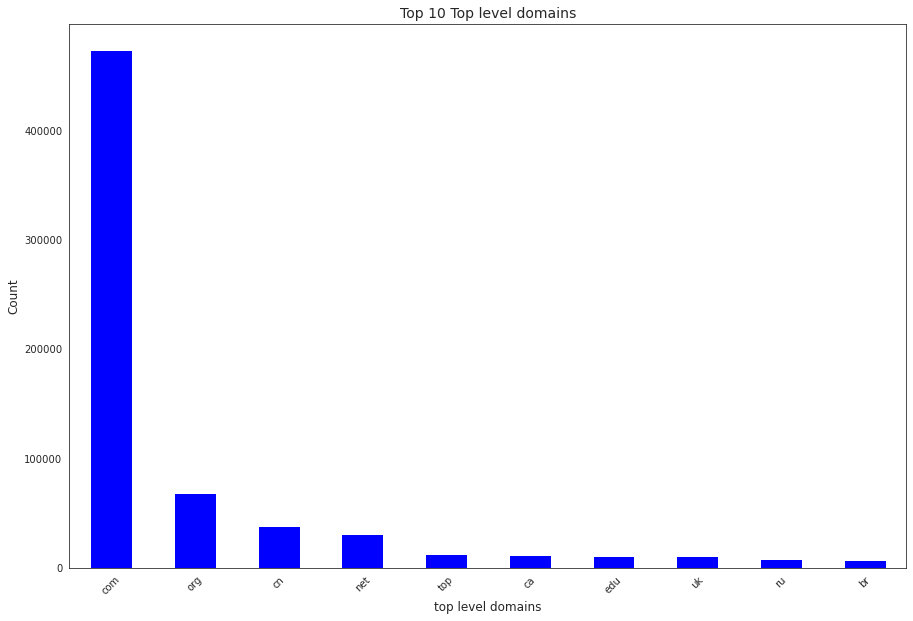

<Figure size 0x288 with 0 Axes>

In [438]:
fig, ax = plt.subplots(figsize=(15, 10))
data.top_domain.value_counts()[:10].plot.bar(color='blue', ax=ax)
plt.title('Top 10 Top level domains',size=14)
plt.xlabel('top level domains',size=12)
plt.ylabel('Count',size=12)
plt.xticks(rotation=45)
plt.figure().set_figwidth(0)
plt.show()


In [439]:
data.domain.describe()

count           822010
unique          455430
top       en.wikipedia
freq             13204
Name: domain, dtype: object

In [440]:
data.domain.value_counts()[:10]

en.wikipedia    13204
youtube          8618
facebook         7735
amazon           4822
imdb             3483
linkedin         3428
tools.ietf       3190
myspace          2923
mylife           2831
manta            2075
Name: domain, dtype: int64

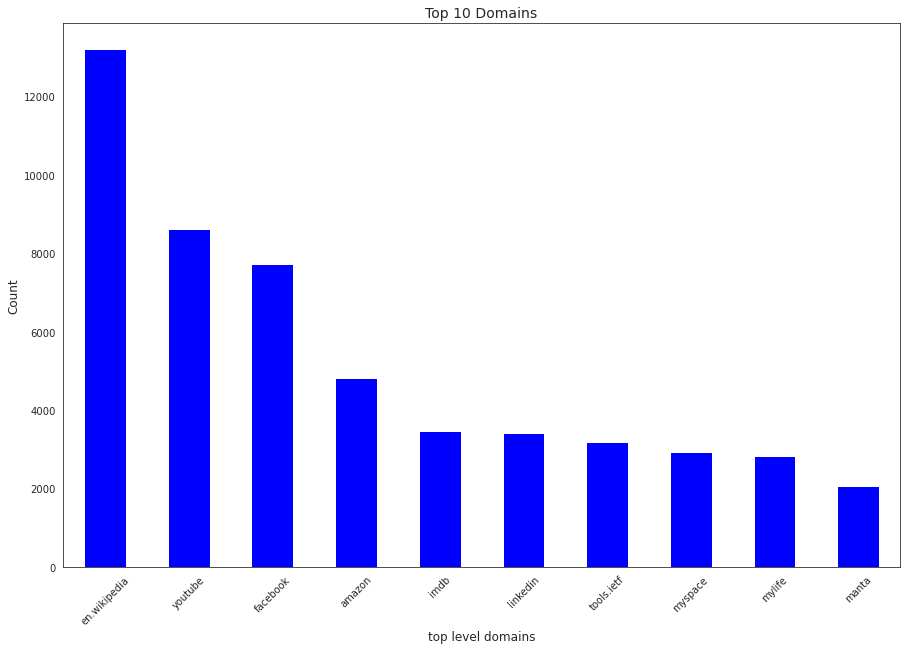

<Figure size 0x288 with 0 Axes>

In [441]:
fig, ax = plt.subplots(figsize=(15, 10))
data.domain.value_counts()[:10].plot.bar(color='blue', ax=ax)
plt.title('Top 10 Domains',size=14)
plt.xlabel('top level domains',size=12)
plt.ylabel('Count',size=12)
plt.xticks(rotation=45)
plt.figure().set_figwidth(0)
plt.show()

In [442]:
data.is_HTTPS.sum()

132796

([<matplotlib.patches.Wedge at 0x7f74ee8f5340>,
 [Text(0.9613448809785448, 0.5346176388937683, 'HTTPS'),
  Text(-0.9647334358711291, -0.5284783796072327, 'Http'),
  Text(1.0999776485437285, -0.007012325164278863, 'IP Address')],
 [Text(0.5243699350792062, 0.2916096212147827, '16.16%, 132796'),
  Text(-0.5262182377478886, -0.2882609343312178, '83.64%, 687546'),
  Text(0.5999878082965792, -0.0038249046350611977, '0.20%, 1668')])

<Figure size 288x288 with 0 Axes>

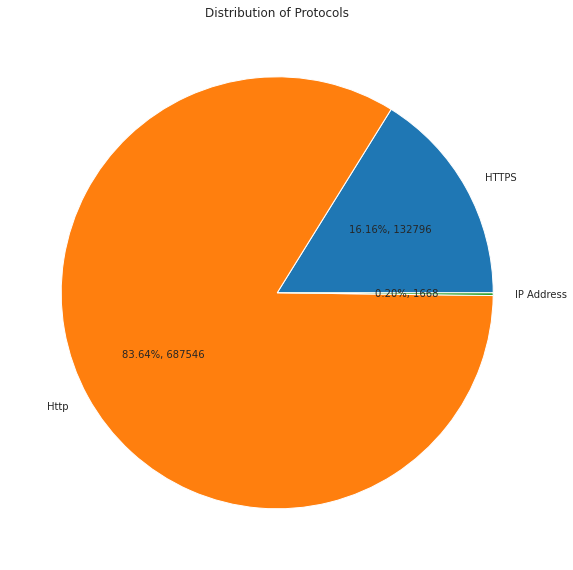

In [443]:
labels=["HTTPS","Http",'IP Address']
ht=data.is_HTTPS.sum()
ip=data.is_IP.sum()
h=data.loc[(data['is_HTTPS']==0)&(data['is_IP']==0)]
y=[ht,len(h),ip]
plt.figure(figsize=plt.figaspect(1))
fig = plt.figure(figsize=(15,30))
ax = fig.add_axes((0,0,.5,1))
ax.set_title('Distribution of Protocols')
plt.pie(y, labels=labels, autopct=lambda p:f'{p:.2f}%, {p*sum(y)/100 :.0f}') 


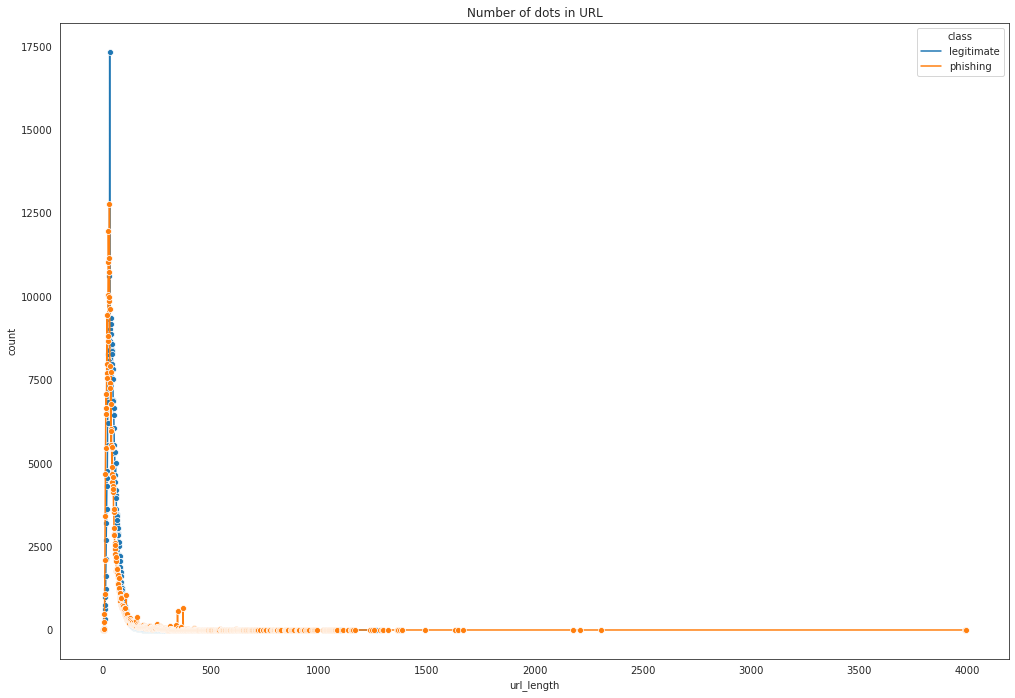

In [444]:
grouped_data = data.groupby(['url_length', 'class']).size().reset_index(name='count')
p=sns.lineplot(x='url_length', y='count', hue='class', data=grouped_data, marker='o')
p.set_title("Number of dots in URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)

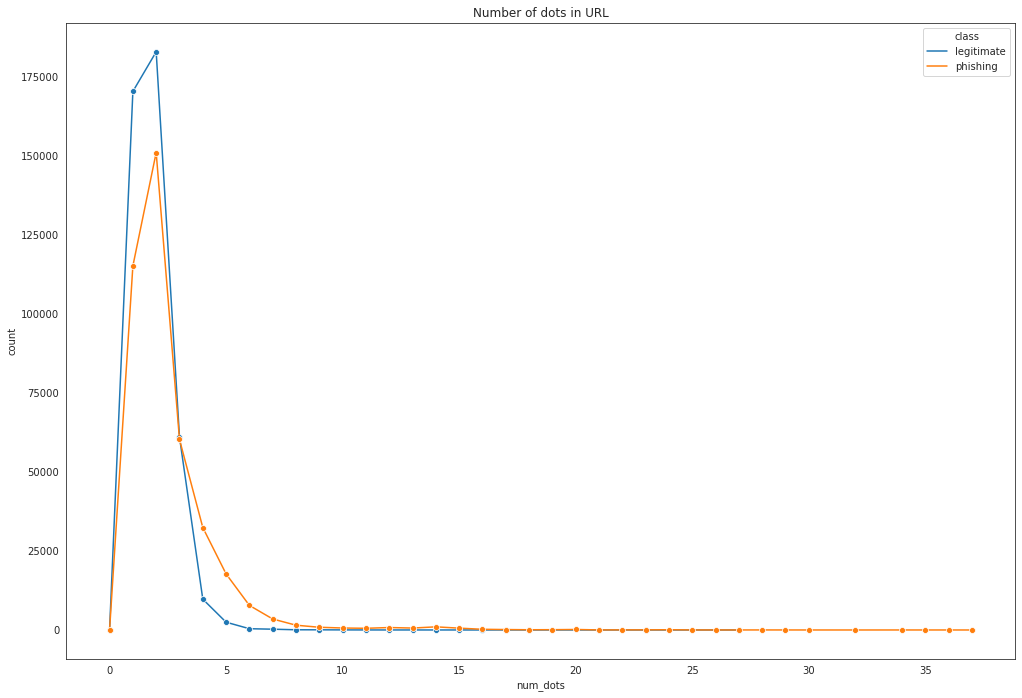

In [445]:
grouped_data = data.groupby(['num_dots', 'class']).size().reset_index(name='count')
p=sns.lineplot(x='num_dots', y='count', hue='class', data=grouped_data, marker='o')
p.set_title("Number of dots in URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)

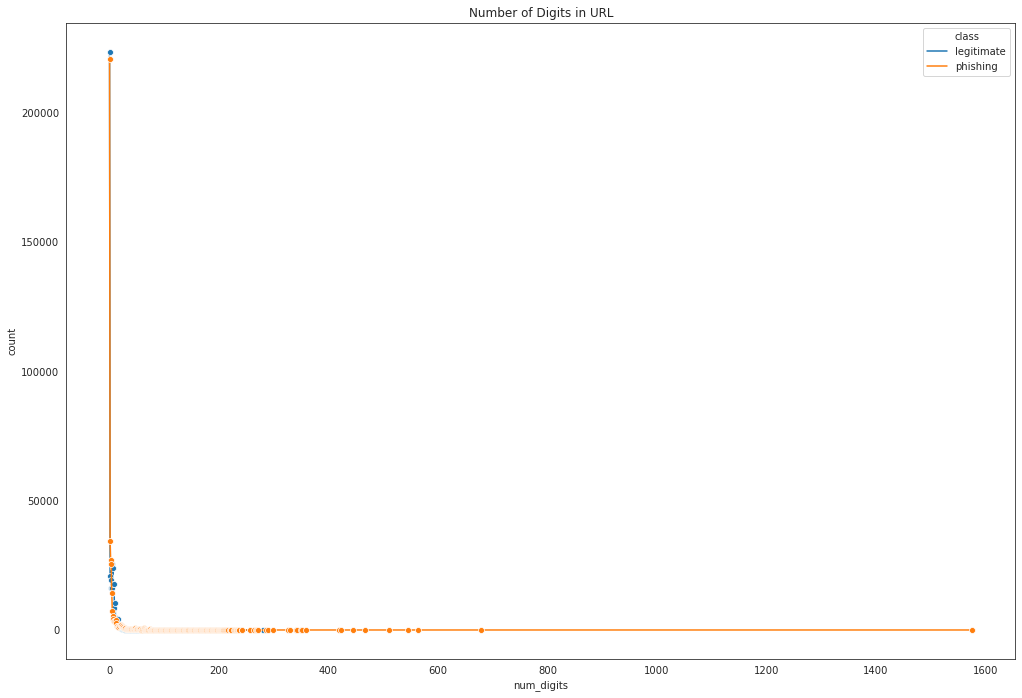

In [446]:

grouped_data = data.groupby(['num_digits', 'class']).size().reset_index(name='count')
p=sns.lineplot(x='num_digits', y='count', hue='class', data=grouped_data, marker='o')
p.set_title("Number of Digits in URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)


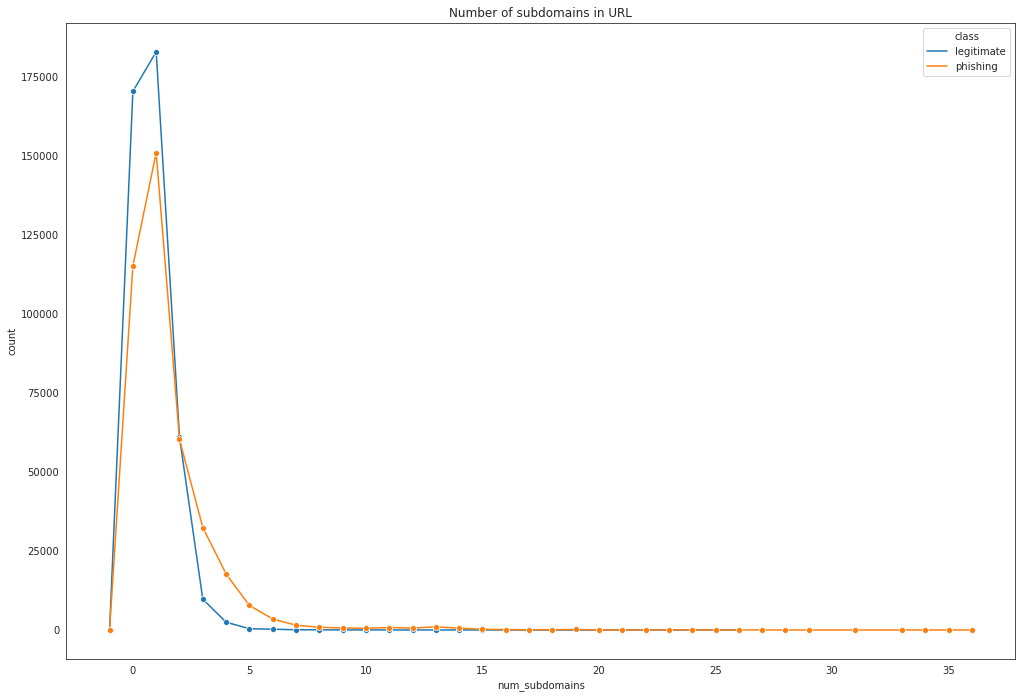

In [447]:

grouped_data = data.groupby(['num_subdomains', 'class']).size().reset_index(name='count')
p=sns.lineplot(x='num_subdomains', y='count', hue='class', data=grouped_data, marker='o')
p.set_title("Number of subdomains in URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)



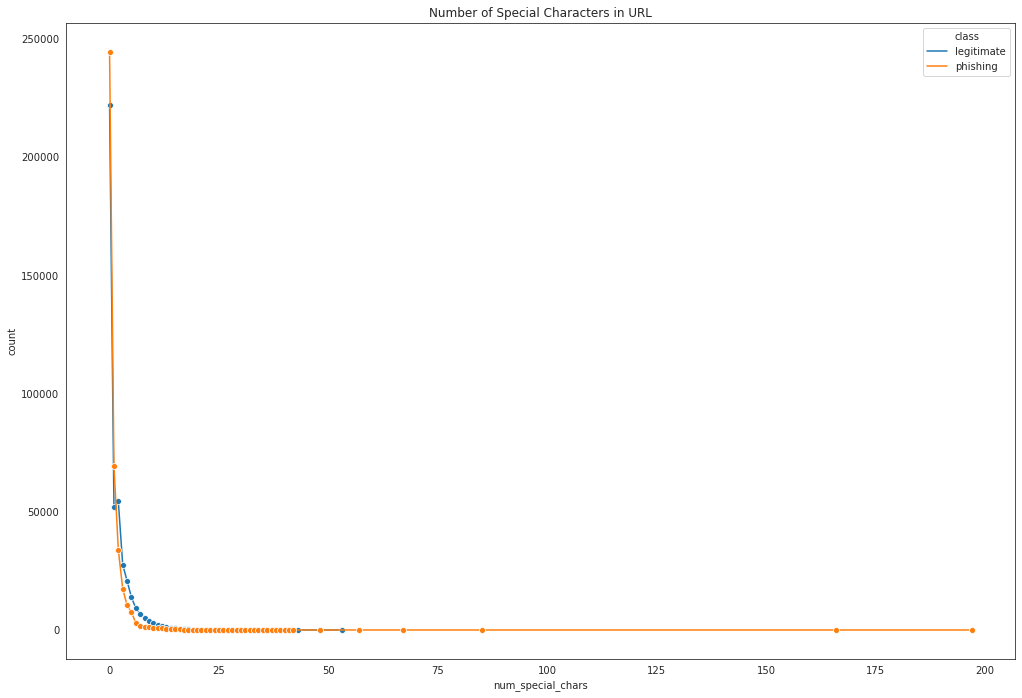

In [448]:
grouped_data = data.groupby(['num_special_chars', 'class']).size().reset_index(name='count')
p=sns.lineplot(x='num_special_chars', y='count', hue='class', data=grouped_data, marker='o')
p.set_title("Number of Special Characters in URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)


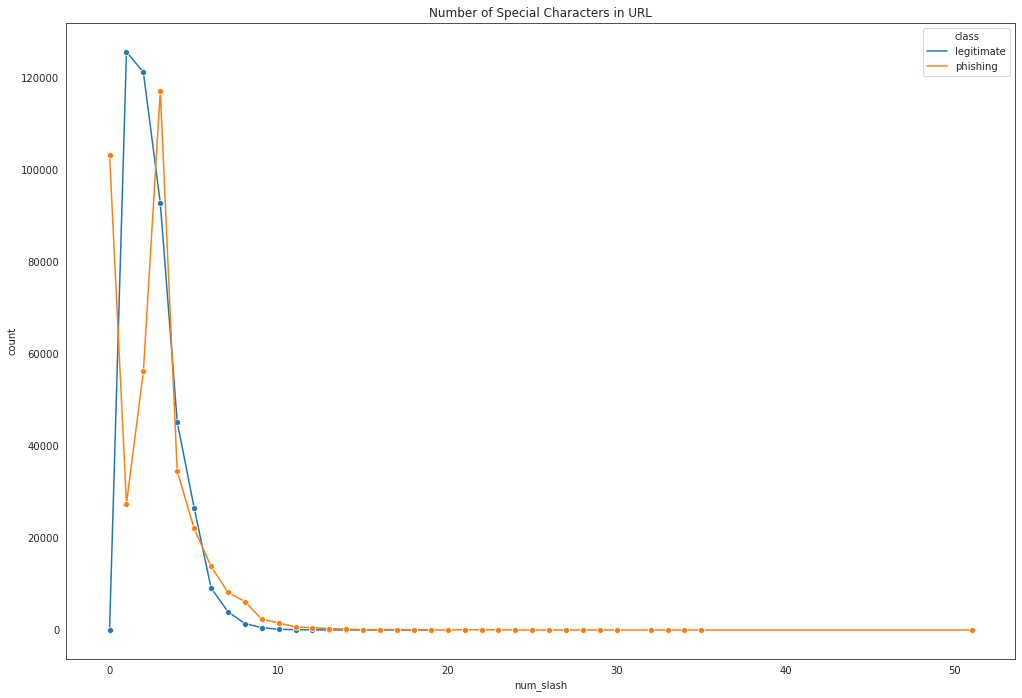

In [449]:
grouped_data = data.groupby(['num_slash', 'class']).size().reset_index(name='count')
p=sns.lineplot(x='num_slash', y='count', hue='class', data=grouped_data, marker='o')
p.set_title("Number of Special Characters in URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)

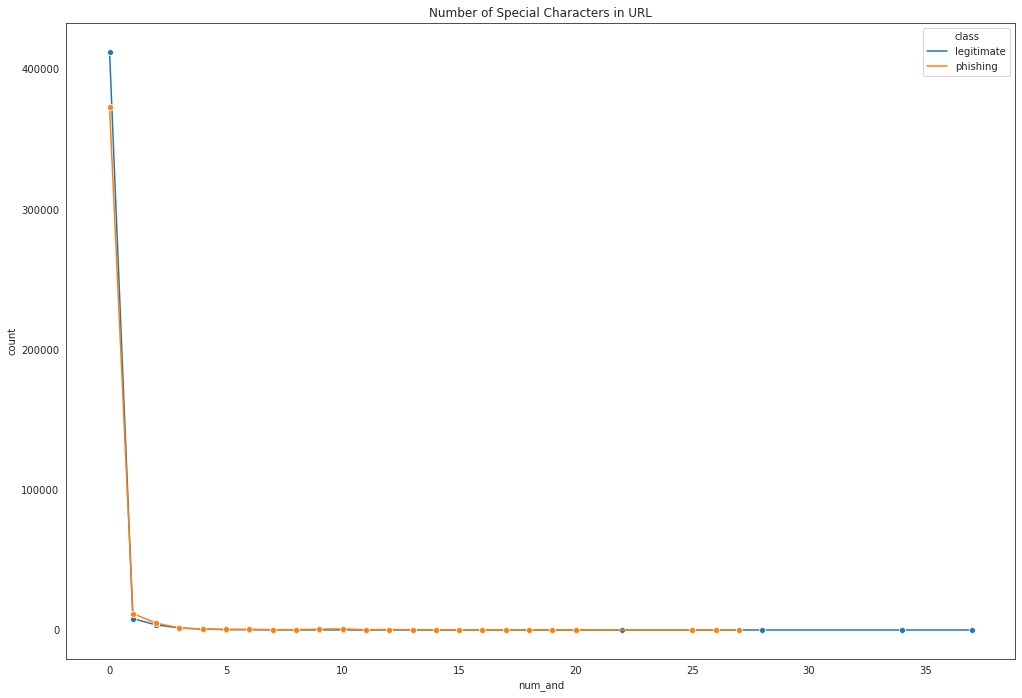

In [450]:
grouped_data = data.groupby(['num_and', 'class']).size().reset_index(name='count')
p=sns.lineplot(x='num_and', y='count', hue='class', data=grouped_data, marker='o')
p.set_title("Number of Special Characters in URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)

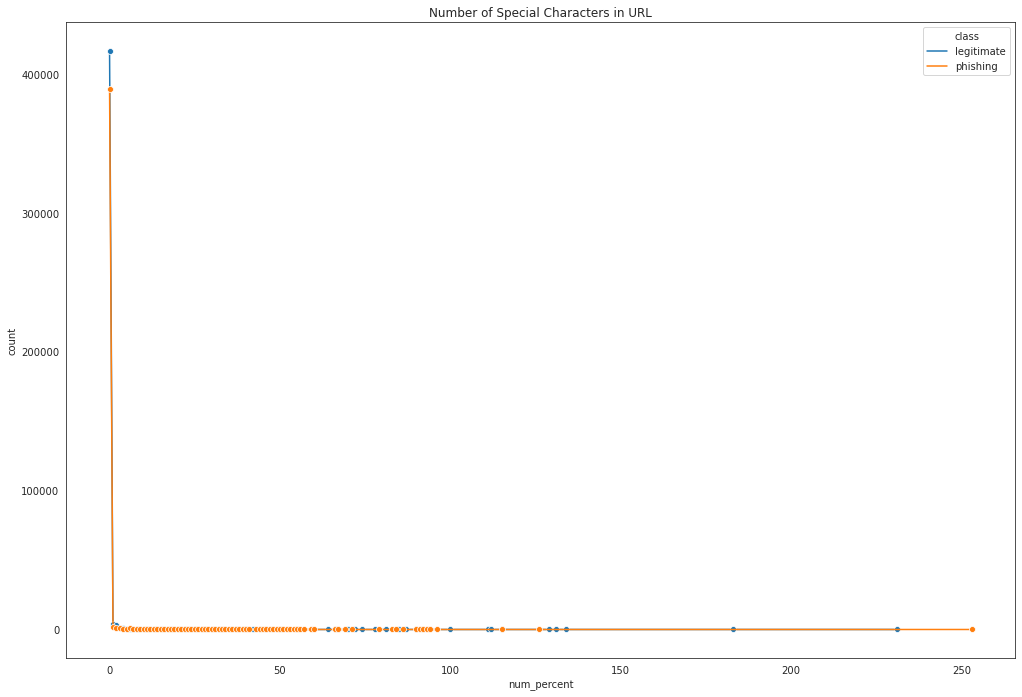

In [451]:
grouped_data = data.groupby(['num_percent', 'class']).size().reset_index(name='count')
p=sns.lineplot(x='num_percent', y='count', hue='class', data=grouped_data, marker='o')
p.set_title("Number of Special Characters in URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)

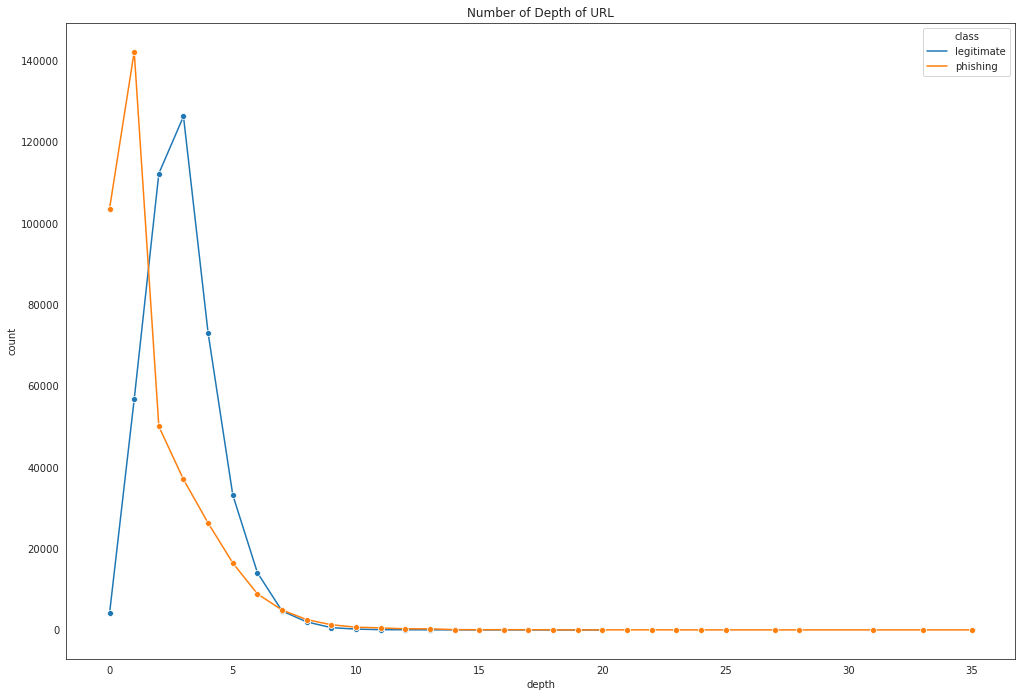

In [452]:
grouped_data = data.groupby(['depth', 'class']).size().reset_index(name='count')
p=sns.lineplot(x='depth', y='count', hue='class', data=grouped_data, marker='o')
p.set_title("Number of Depth of URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)

In [453]:
data

,url,status,url_length,class,num_special_chars,num_subdomains,num_digits,num_dots,top_domain,domain,is_IP,is_HTTPS,depth,num_slash,num_and,num_percent
0,0000111servicehelpdesk.godaddysites.com,0,39,phishing,0,1,7,2,com,0000111servicehelpdesk.godaddysites,0,0,1,0,0,0
1,000011accesswebform.godaddysites.com,0,36,phishing,0,1,6,2,com,000011accesswebform.godaddysites,0,0,1,0,0,0
2,00003.online,0,12,phishing,0,0,5,1,online,00003,0,0,1,0,0,0
3,0009servicedeskowa.godaddysites.com,0,35,phishing,0,1,4,2,com,0009servicedeskowa.godaddysites,0,0,1,0,0,0
4,000n38p.wcomhost.com,0,20,phishing,0,1,5,2,com,000n38p.wcomhost,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822005,zzufg.com,0,9,phishing,0,0,0,1,com,zzufg,0,0,1,0,0,0
822006,zzu.li,0,6,phishing,0,0,0,1,li,zzu,0,0,1,0,0,0
822007,zzz.co.uk,0,9,phishing,0,1,0,2,uk,zzz.co,0,0,1,0,0,0
822008,zzzoolight.co.za,0,16,phishing,0,1,0,2,za,zzzoolight.co,0,0,1,0,0,0
